In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from PIL import Image, ImageOps, ImageFilter
import random

In [2]:
! pip install torchsummary

In [3]:
from torchsummary import summary

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [22]:


def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler : lr_scheduler = None,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    running_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    losses = []
    acc = 0.0
    total = 0
    if scheduler == None : 
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    for i, (inputs , labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        if train_mode : 
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            acc += (preds == labels).sum().item()
            total += len(labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(i+1))
            losses.append(loss.item())
            
        else:
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                acc += (preds == labels).sum().item()
                total += len(labels)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                progress_bar.set_postfix(loss=running_loss/(i+1))
                losses.append(loss.item())
    print("Epoch finished with loss and accuracy : " ,running_loss/len(data_loader) ,  acc/total)
    scheduler.step(running_loss/len(data_loader))
    print("new lr  : " , f'{optimizer.param_groups[0]["lr"]:.6f}')
    
    return losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    optimizer=None,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """


    if optimizer is None : 
        optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_losses_epoch = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        print("Validation : ")
        val_losses_epoch = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        train_losses += train_losses_epoch
        val_losses += val_losses_epoch
    
    return train_losses, val_losses




def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    
    model.eval()
    corrects = 0
    total = 0
    for i , (inputs, labels) in enumerate(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == labels).sum().item()
        total += len(labels)
    
    return corrects / total



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    
    train_losses_smoothed = np.convolve(train_losses, np.ones(c_window), 'valid') / c_window
    if val_losses is not None : 
        val_losses_smoothed = np.convolve(val_losses, np.ones(c_window), 'valid') / c_window

    if val_losses is not None : 
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses_smoothed, label='Training Loss')
        plt.plot(val_losses_smoothed, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    else : 
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses_smoothed, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    


In [6]:
class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img


class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=1.0),
            Solarization(p=0.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.transform_prime = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                        saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=0.1),
            Solarization(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return y1, y2

transform_ = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])


In [7]:

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True , transform=Transform())
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True ,transform=transform_)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:08<00:00, 20247718.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


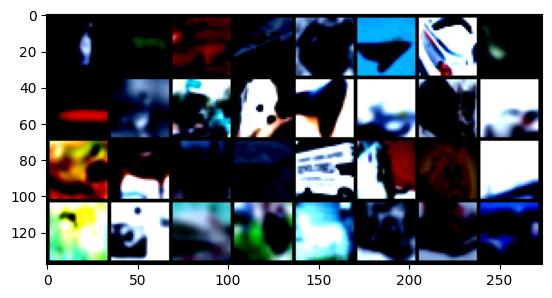

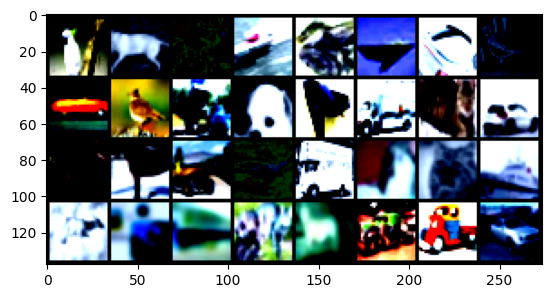

In [8]:
def imshow(img):
    
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, data in enumerate(train_loader, 0):
    imshow(torchvision.utils.make_grid(data[0][0][:32]))
    imshow(torchvision.utils.make_grid(data[0][1][:32]))
    if i == 0:
        break

In [9]:
class BarlowTwins(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torchvision.models.resnet50(weights=None)
        self.backbone.fc = nn.Identity()

        # projector
        sizes = [2048] + list([2048 , 2048 , 2048])
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)


    def forward(self, x):
        return self.projector(self.backbone(x))

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()



class BT_loss(nn.Module):
    
    def __init__(self , device ,  lamdb: float = 0.01 ) :
        super(BT_loss, self).__init__()
        self.lamdb = lamdb
        self.device = device


    def forward(self,
                y1: torch.Tensor,
                y2: torch.Tensor,
                ) -> torch.Tensor:
        
        y1 = (y1 - y1.mean(0)) / y1.std(0)
        y2 = (y2 - y2.mean(0)) / y2.std(0)
        
        N = y1.size(0)
        D = y1.size(1)
        
        c = torch.mm(y1.T, y2) / N
        c_diff = (c - torch.eye(D, device=self.device)).pow(2)
        c_diff[~torch.eye(D, dtype=bool)] *= self.lamdb
        loss = c_diff.sum()
        
        
        return loss

        

In [10]:
BT_model = BarlowTwins().to(device)
summary(BT_model , (3 , 32 , 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [11]:
def train_BT(BT_model: nn.Module,
             train_loader: torch.utils.data.DataLoader,
             device: torch.device,
             epochs: int = 10,
             lr: float = 0.001,
            ) -> List : 


    losses = []
    BT_model.to(device)

    criterion = BT_loss(lamdb=0.004 , device=device).to(device)
    optimizer = optim.Adam(BT_model.parameters(), lr=lr , weight_decay=1.5*1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    for epoch in range(epochs) : 
        
        BT_model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        for i , ((x1 , x2) , _) in progress_bar :
            x1 , x2 = x1.to(device) , x2.to(device)
            
            optimizer.zero_grad()
            
            y1 = BT_model(x1)
            y2 = BT_model(x2)
            
            loss = criterion(y1 , y2)
            
            loss.backward()
            losses.append(loss.detach().cpu().item())
            
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix({'loss': running_loss / (i + 1)})
        
        print(f"Epoch {epoch + 1} - Training loss: {running_loss / len(train_loader)}")
        scheduler.step(running_loss/len(train_loader))
        print("new lr  : " , f'{optimizer.param_groups[0]["lr"]:.6f}')
        


    return losses

In [12]:
losses = train_BT(BT_model=BT_model ,  train_loader=train_loader , device=device ,epochs=100 , lr = 0.002)

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Training loss: 2203.6068028041295
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Training loss: 1736.6913408551898
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Training loss: 1623.364486382932
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 - Training loss: 1585.3856662049586
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5 - Training loss: 1588.0530881297832
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6 - Training loss: 1543.7472833127392
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7 - Training loss: 1449.7337577975527
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8 - Training loss: 1352.4525177624762
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9 - Training loss: 1272.9547785544883
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10 - Training loss: 1246.9903140943877
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11 - Training loss: 1184.313291588608
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12 - Training loss: 1111.737251748844
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13 - Training loss: 1093.4527544294085
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14 - Training loss: 1044.5401608214086
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15 - Training loss: 975.4422766237843
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16 - Training loss: 939.3784347845584
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17 - Training loss: 884.8891477000957
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18 - Training loss: 832.9649100790218
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19 - Training loss: 771.5419981041733
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20 - Training loss: 733.4252817582111
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21 - Training loss: 689.4023026446907
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22 - Training loss: 656.5948162468112
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23 - Training loss: 621.2846539555763
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24 - Training loss: 587.1226703877352
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25 - Training loss: 551.5853526835539
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26 - Training loss: 534.2636148880939
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27 - Training loss: 505.9390613789461
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28 - Training loss: 488.2197693805305
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29 - Training loss: 469.1997208887217
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30 - Training loss: 454.76618583834903
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31 - Training loss: 439.34992451570474
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32 - Training loss: 428.91503516995175
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33 - Training loss: 414.41975091428174
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34 - Training loss: 399.31897330770687
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35 - Training loss: 391.3757243253747
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36 - Training loss: 381.9580775669643
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37 - Training loss: 373.7846226594886
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38 - Training loss: 366.6291257897202
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39 - Training loss: 357.2851011315171
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40 - Training loss: 351.7200340738102
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41 - Training loss: 344.94564959467675
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42 - Training loss: 338.0552086343571
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43 - Training loss: 331.757005341199
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44 - Training loss: 327.9604485959423
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45 - Training loss: 323.2259990147182
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46 - Training loss: 317.6578492145149
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47 - Training loss: 312.94982147216797
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48 - Training loss: 307.7983473174426
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49 - Training loss: 302.93071591124243
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50 - Training loss: 299.4991462863222
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51 - Training loss: 293.84994973941724
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52 - Training loss: 291.18287876674106
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53 - Training loss: 290.3835783977898
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54 - Training loss: 284.0242880217883
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55 - Training loss: 282.9649895648567
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56 - Training loss: 280.30941250859473
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57 - Training loss: 274.1504836569027
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58 - Training loss: 272.36818002194775
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59 - Training loss: 267.4757731690699
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60 - Training loss: 268.0087233562859
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61 - Training loss: 266.0387984295281
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62 - Training loss: 262.0363990627989
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63 - Training loss: 261.85522694490396
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64 - Training loss: 258.34272532560385
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65 - Training loss: 254.55293593114737
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66 - Training loss: 253.0552355707908
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67 - Training loss: 248.8487612665916
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68 - Training loss: 249.93448459858797
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69 - Training loss: 245.1599521247708
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70 - Training loss: 244.584928006542
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71 - Training loss: 242.7826099006497
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72 - Training loss: 241.55472385640047
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73 - Training loss: 240.05857599998006
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74 - Training loss: 237.3862680707659
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75 - Training loss: 236.5863543140645
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76 - Training loss: 234.01637641751037
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77 - Training loss: 231.58847100394112
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78 - Training loss: 230.59845609081034
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79 - Training loss: 229.15071829971
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80 - Training loss: 228.38274874005998
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81 - Training loss: 226.38304262745137
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82 - Training loss: 224.3741068158831
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83 - Training loss: 223.34624395565112
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84 - Training loss: 219.7240205881547
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85 - Training loss: 220.13647126178353
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86 - Training loss: 218.96721034147302
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87 - Training loss: 217.05247162799446
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88 - Training loss: 215.56717526182837
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89 - Training loss: 215.07127777411014
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90 - Training loss: 212.70080823314433
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91 - Training loss: 211.83030669543209
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92 - Training loss: 212.80054559513013
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93 - Training loss: 210.47436803700973
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94 - Training loss: 208.54138020106726
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95 - Training loss: 208.35946266018615
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96 - Training loss: 205.7253809559102
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97 - Training loss: 205.11751073720504
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98 - Training loss: 204.86125759202608
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99 - Training loss: 203.96133905527543
new lr  :  0.002000


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100 - Training loss: 201.4911497466418
new lr  :  0.002000


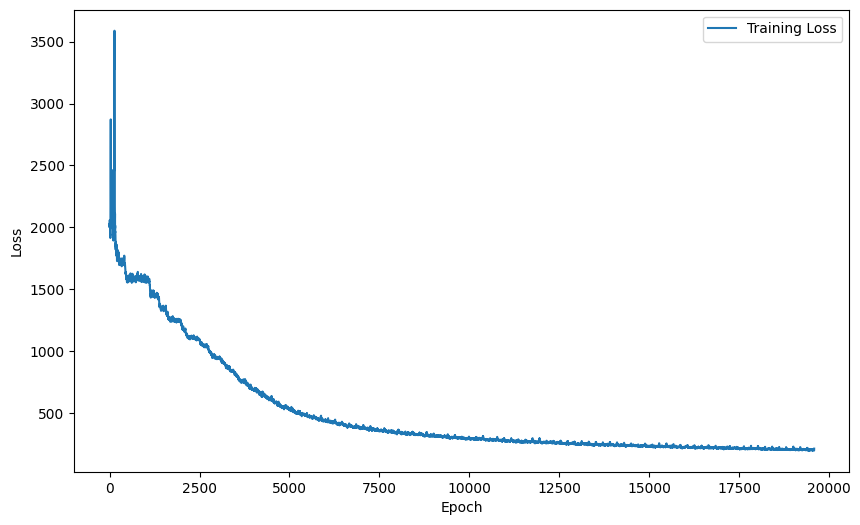

In [13]:
plot_losses(losses , None)

In [14]:
#PATH = '/kaggle/input/bt-model-resnet-50-3/BT_model_resnet_50_3.pth'

# pretrained_dict = torch.load(PATH , weights_only=True)
# BT_model = BarlowTwins().to(device)
# BT_model.load_state_dict(pretrained_dict)

In [15]:
torch.save(BT_model.state_dict(), 'BT_model_resnet_50_100Epoch.pth')

In [16]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

download_file("BT_model_resnet_50_100Epoch.pth" , "BT_model_resnet_50_100Epoch")

/kaggle/working/BT_model_resnet_50_100Epoch.zip

In [17]:
#BT_model = BarlowTwins().to(device)
#BT_model.load_state_dict(torch.load(PATH))


In [18]:
class Classifier_with_BT(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torchvision.models.resnet50(weights=None)
        self.backbone.fc = nn.Identity()
        
        sizes = [2048] + list([2048 , 2048 , 2048])
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)
        
        #classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048, 10),
            nn.Softmax(dim=1)
        )


            

    def forward(self, x):
        return self.classifier(self.projector(self.backbone(x)))

In [28]:
#load the BT_model
# BT_model_pre_trained = BarlowTwins().to(device)
# BT_model_pre_trained.load_state_dict(torch.load(PATH))
# BT_model_dict = BT_model_pre_trained.state_dict()
BT_model_dict = BT_model.state_dict()

classifier = Classifier_with_BT().to(device)
classifier_dict = classifier.state_dict()

#copy the weights from BT_model to classifier
for name, param in BT_model_dict.items():
    if name in classifier_dict:
        classifier_dict[name].data.copy_(param.data)
        
classifier.load_state_dict(classifier_dict)

#freezing the weights of the backbone and the projector

for param in classifier.backbone.parameters():
    param.requires_grad = False
    
for param in classifier.projector.parameters():
    param.requires_grad = False
    
summary(classifier , (3 , 32 , 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [20]:
transform_ = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True , transform=transform_)

val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True ,transform=transform_)

train_loader_c = DataLoader(Subset(val_set, range(0, 8000)), batch_size=128, shuffle=True)
val_loader_c = DataLoader(Subset(val_set, range(8000, 10000)), batch_size=256, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [29]:
optimizer = optim.Adam([
    {'params': classifier.backbone.parameters(), 'lr': 0.000},
    {'params': classifier.projector.parameters(), 'lr': 0.0001},
    {'params': classifier.classifier.parameters()}
], lr=0.001)

train_losses, val_losses = train(train_loader_c, val_loader_c, classifier, epochs=20, optimizer=optimizer)

Epoch 1
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.9829001105020916 0.474375
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8857118785381317 0.5725
new lr  :  0.000000
Epoch 2
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8785517783392043 0.580375
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.87105330824852 0.5885
new lr  :  0.000000
Epoch 3
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8599228196673923 0.5985
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8643305152654648 0.5965
new lr  :  0.000000
Epoch 4
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8581516818394737 0.6015
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8635066002607346 0.5955
new lr  :  0.000000
Epoch 5
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8524355680223494 0.6075
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8762312829494476 0.5835
new lr  :  0.000000
Epoch 6
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8505416408417716 0.610125
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8623254746198654 0.599
new lr  :  0.000000
Epoch 7
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8436353490466164 0.6155
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.866723969578743 0.593
new lr  :  0.000000
Epoch 8
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8493276474967835 0.611
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8568023592233658 0.6025
new lr  :  0.000000
Epoch 9
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.839879238416278 0.618375
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8542135059833527 0.6065
new lr  :  0.000000
Epoch 10
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8447501243106903 0.61525
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8564518243074417 0.604
new lr  :  0.000000
Epoch 11
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8442091071416462 0.617
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8584658205509186 0.601
new lr  :  0.000000
Epoch 12
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.836218309780908 0.62375
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.86129729449749 0.6
new lr  :  0.000000
Epoch 13
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8346217397659543 0.624875
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8705807626247406 0.591
new lr  :  0.000000
Epoch 14
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8422024439251612 0.6175
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8567127734422684 0.6055
new lr  :  0.000000
Epoch 15
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8357566822142828 0.62525
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8598597347736359 0.5995
new lr  :  0.000000
Epoch 16
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8400803728709145 0.619625
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8681053221225739 0.592
new lr  :  0.000000
Epoch 17
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8345217969682481 0.626125
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8659019768238068 0.5945
new lr  :  0.000000
Epoch 18
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8367083962001498 0.62475
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8652399629354477 0.5965
new lr  :  0.000000
Epoch 19
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8378527164459229 0.623
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8591897785663605 0.6015
new lr  :  0.000000
Epoch 20
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.8367451013080658 0.6245
new lr  :  0.000000
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  1.857498586177826 0.603
new lr  :  0.000000


In [30]:
classifier_2 = Classifier_with_BT().to(device)
train_losses, val_losses = train(train_loader_c, val_loader_c, classifier_2, epochs=20, lr=0.0003 )

Epoch 1
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.278335064176529 0.163375
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.259363740682602 0.184
new lr  :  0.000300
Epoch 2
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2354923732697016 0.209875
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.22622287273407 0.2265
new lr  :  0.000300
Epoch 3
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.208427342157515 0.243375
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2112399637699127 0.246
new lr  :  0.000300
Epoch 4
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.184308653786069 0.268375
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1974189579486847 0.257
new lr  :  0.000300
Epoch 5
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.170414512119596 0.2845
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.181060791015625 0.2725
new lr  :  0.000300
Epoch 6
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.158657259411282 0.294
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1751673817634583 0.276
new lr  :  0.000300
Epoch 7
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.151081467431689 0.302
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1862390637397766 0.27
new lr  :  0.000300
Epoch 8
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1602922961825417 0.29275
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1695224940776825 0.2865
new lr  :  0.000300
Epoch 9
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1192795397743347 0.3345
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1548327207565308 0.299
new lr  :  0.000300
Epoch 10
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.115914715660943 0.33925
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.15109121799469 0.303
new lr  :  0.000300
Epoch 11
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1221817958922613 0.334625
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.147101104259491 0.3115
new lr  :  0.000300
Epoch 12
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1145478316715787 0.343375
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.166963666677475 0.293
new lr  :  0.000300
Epoch 13
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.145716557427058 0.311625
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1543412804603577 0.304
new lr  :  0.000300
Epoch 14
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.149572421634008 0.30825
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2245984971523285 0.235
new lr  :  0.000300
Epoch 15
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1985580618419345 0.25775
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2140022814273834 0.245
new lr  :  0.000300
Epoch 16
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.1787907623109364 0.279625
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2006562054157257 0.2535
new lr  :  0.000300
Epoch 17
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.196454649879819 0.261625
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.199895888566971 0.2595
new lr  :  0.000300
Epoch 18
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.177531435376122 0.279125
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.219583749771118 0.238
new lr  :  0.000300
Epoch 19
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2004837649209157 0.257875
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.201353967189789 0.258
new lr  :  0.000300
Epoch 20
-------------------------------


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.178391316580394 0.282125
new lr  :  0.000300
Validation : 


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch finished with loss and accuracy :  2.2173798382282257 0.2395
new lr  :  0.000300
